In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing #model_selection, 
from XGBoostPackage import xgbClass, modelfit
#from CrossValidation import CVScore
from sklearn.grid_search import GridSearchCV

import xgboost as xgb
import datetime
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.cross_validation import train_test_split
#now = datetime.datetime.now()

train = pd.read_csv('./input/train_further_additional_feature.csv', parse_dates=['timestamp'])
train = train.drop(['Unnamed: 0'], axis=1)
test = pd.read_csv('./input/test_further_additional_feature.csv', parse_dates=['timestamp'])
test = test.drop(['Unnamed: 0'], axis=1)
macro = pd.read_csv('./input/macro.csv', parse_dates=['timestamp'])

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

id_test = test.id
#multiplier = 0.969

def RMSLE_(y_val, y_val_pred):
    return np.sqrt(np.mean((np.log(y_val+1)-np.log(y_val_pred+1))**2))
RMSLE = make_scorer(RMSLE_, greater_is_better=False) 

def RMSE_(y_val, y_val_pred):
    return np.sqrt(np.mean((y_val-y_val_pred)**2))
RMSE = make_scorer(RMSE_, greater_is_better=False)

from time import time

train_df = pd.read_csv('../input/train.csv').set_index('id')
test_df = pd.read_csv('../input/test.csv').set_index('id')

df_fixup = pd.read_excel('../input/BAD_ADDRESS_FIX.xlsx')
df_fixup.set_index('id', inplace=True)

fix_train_indexset = set(df_fixup[df_fixup.index &lt; train_df.index.max()].index)
bad_train_indexset = set(train_df[train_df.kremlin_km == train_df.kremlin_km.min()].index)
unfixed_set = bad_train_indexset.difference(fix_train_indexset)

train_df.drop(unfixed_set, inplace=True)

df = pd.concat([train_df, test_df])

# There should be a call to do this, I just don't know it ;) - edit:  update might be able to do it, but I think the columns would have to be NaN'd out before it works.  So these two lines can stay IMO...
for c in df_fixup.columns:
    df.loc[df_fixup.index, c] = df_fixup[c]

In [83]:
#train[['mean_price_persqm_raion','sub_area','year']][train['sub_area']=='Bibirevo']
dict1=dict(zip(train['sub_area'],train['mean_price_persqm_raion']))
test['mean_price_persqm_raion']=test['sub_area'].apply(lambda x: dict1[x])
del dict1
dict1=dict(zip(train['sub_area'],train['mean_price_raion']))
test['mean_price_raion']=test['sub_area'].apply(lambda x: dict1[x])
del dict1
dict1=dict(zip(zip(train['sub_area'],train['year']),train['mean_price_raion_year']))
test['mean_price_raion_year']=test.apply(lambda x: dict1[(x['sub_area'],x['year'])]\
                                         if (x['sub_area'],x['year']) in dict1 else np.nan,
                                         axis=1)
del dict1

In [84]:
#clean data
def build_year_clean(train):
    #train.build_year=train.build_year.apply(int)
    train.build_year[train.build_year == 20052009] = 2005
    train.build_year[train.build_year == 0] = np.NaN
    train.build_year[train.build_year == 1] = np.NaN
    train.build_year[train.build_year == 20] = 2000
    train.build_year[train.build_year == 215] = 2015
    train.build_year[train.build_year == 4965] = np.NaN     
    train.build_year[train.build_year == 3] = np.NaN
    train.build_year[train.build_year == 71] = np.NaN
build_year_clean(train)
build_year_clean(test)

bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
train.product_type.value_counts(normalize= True)
test.product_type.value_counts(normalize= True)
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN
train.floor.describe(percentiles= [0.9999])
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN
train.material.value_counts()
test.material.value_counts()
train.state.value_counts()
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = 3#np.NaN
test.state.value_counts()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


2.0    2662
1.0    2266
3.0    1913
4.0     127
Name: state, dtype: int64

In [85]:
# brings error down a lot by removing extreme price per sqm
train.loc[train.full_sq == 0, 'full_sq'] = 50
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
# def Time_Feature(train):
#     train['year'] = train.timestamp.dt.year
#     train['month'] = train.timestamp.dt.month
#     train['woy'] = train.timestamp.dt.weekofyear
#     train['dow'] = train.timestamp.dt.dayofweek
#     train['dom'] = train.timestamp.dt.days_in_month
# Time_Feature(train)
# Time_Feature(test)
# test['year'] = test.timestamp.dt.year
# test['month'] = test.timestamp.dt.month
# test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
#train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
#train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

#test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
#test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

# train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
# test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

# train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
# test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

# train['non_living_area'] = (train['full_sq']-train['life_sq'])*100/train['full_sq']
# test['non_living_area'] = (test['full_sq']-test['life_sq'])*100/train['full_sq']

# def House_Characteristics(train):
#     train['floor_from_top'] = train['max_floor'] - train['floor']
#     train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
#     train['room_size'] = (train['life_sq']-train['kitch_sq']) / train['num_room'].astype(float)
#     train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)
#     train['rel_life_sq'] = train['life_sq'] / train['full_sq'].astype(float)
#     train['non_living_area'] = (train['full_sq']-train['life_sq'])*100/train['full_sq']
#     train['age_at_sale'] = (train['timestamp']-train['build_year'].apply(pd.to_datetime))/datetime.timedelta(days=365)

In [86]:
# ((train['timestamp']-train['build_year'].apply(pd.to_datetime))/datetime.timedelta(days=365)).hist()#
# #.apply(lambda x: x.total_seconds())

In [87]:
# plt.figure(figsize=(12,8))
# plt.subplot(2,2,1)
# sns.violinplot(data=train,x='year',y='price_doc')
# plt.ylim(-.1e8,.3e8)
# plt.subplot(2,2,2)
# sns.violinplot(data=train,x='month',y='price_doc')
# plt.ylim(-.1e8,.2e8)


In [88]:
train_lat_long=pd.read_csv("./input/train_lat_lon.csv")
test_lat_long=pd.read_csv("./input/test_lat_lon.csv")
# train_lat_long.head()

In [89]:
train=train.merge(train_lat_long[["id","lat","lon"]],left_on='id',right_on='id')
del train_lat_long
test=test.merge(test_lat_long[["id","lat","lon"]],left_on='id',right_on='id')
del test_lat_long
train.loc[train['id']==11054]

,sub_area,mean_building_height,mean_price_persqm_raion,year,mean_price_raion_year,mean_price_raion,distance_from_kremlin,year_month,n_sales_permonth,appartment_name,n,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_

In [90]:
# train.head()

In [91]:
# sns.lmplot(x="lon",y="lat",scatter_kws={'alpha':.4,'s':30}, size=9, fit_reg=False, data=train)
# axes=plt.gca()

In [92]:
import math
def cart2rho(x, y):
    rho = np.sqrt(x**2 + y**2)
    return rho


def cart2phi(x, y):
    phi = np.arctan2(y, x)
    return phi

#center long/lat of moscow: (37.6173, 55.7558)
def rotation_x(row, alpha):
    y = row['lat']-55.7558
    x = row['lon']-(37.6173)
    return x*math.cos(alpha) + y*math.sin(alpha)


def rotation_y(row, alpha):
    y = row['lat']-55.7558
    x = row['lon']-(37.6173)
    return y*math.cos(alpha) - x*math.sin(alpha)


def add_rotation(degrees, df):
    namex = "rot" + str(degrees) + "_X"
    namey = "rot" + str(degrees) + "_Y"

    df['num_' + namex] = df.apply(lambda row: rotation_x(row, math.pi/(180/degrees)), axis=1)
    df['num_' + namey] = df.apply(lambda row: rotation_y(row, math.pi/(180/degrees)), axis=1)

    return df

def add_dist_to_center(row):
    y = row['lat']-55.7558
    x = row['lon']-(37.6173)
    return cart2phi(x,y)

def operate_on_coordinates(tr_df, te_df):
    for df in [tr_df, te_df]:
        #polar coordinates system
#         df["num_rho"] = df.apply(lambda x: cart2rho(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
#         df["num_phi"] = df.apply(lambda x: cart2phi(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
#         #rotations
        for angle in [30,60]:
            df = add_rotation(angle, df)
        #df['dist_to_center']=df.apply(lambda row: add_dist_to_center(row), axis=1)

    return tr_df, te_df

train, test= operate_on_coordinates(train, test)

In [93]:
# sns.regplot(data=train.sample(1000),x="dist_to_center",y="price_doc")

In [94]:
# train['full_sq'].hist(bins=100, figsize=(12,8))

In [95]:
# y_train = train["price_doc"]
# X_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
# X_test = test.drop(["id", "timestamp"], axis=1)
y_train = train["price_doc"]
#pd.DataFrame({'id': train.id, 'price_doc': y_train}).to_csv('./input/y_train_further_additional_feature_filtered.csv')
X_train = train.drop(["id", "timestamp", #"price_doc", #'mean_price_raion_year', \
                      #'mean_price_raion', 'mean_price_persqm_raion', 
                      ], axis=1)
X_test = test.drop(["id", "timestamp"], axis=1)
X_test = X_test[X_train.drop('price_doc',axis=1).columns]
del train
del test

## [1] "id"                       "id_metro"                
## [3] "id_railroad_station_walk" "id_railroad_station_avto"
## [5] "id_big_road1"             "id_big_road2"            
## [7] "id_railroad_terminal"     "id_bus_terminal"
#col_to_remove=["ID_metro","ID_railroad_station_walk","ID_railroad_station_avto","ID_big_road1","ID_big_road2","ID_railroad_terminal","ID_bus_terminal"]
def column_transform(X_train):
#     for c in col_to_remove:
#         del X_train[c]
    for c in X_train.columns:
        if X_train[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[c].values)) 
            X_train[c] = lbl.transform(list(X_train[c].values))
            #X_train.drop(c,axis=1,inplace=True)
        
column_transform(X_train)
column_transform(X_test)

In [96]:
X_train.shape

(30033, 343)

In [97]:
original_feats=pd.read_csv('./input/train.csv').drop(['price_doc','id','timestamp'],axis=1).columns
cols_to_drop=pd.read_table("cols_to_drop.txt").iloc[1:62]
original_feats_toDrop=cols_to_drop['ReduceVIF fit'].apply(lambda x: x.split(' ')[1])
original_feats=[i for i in original_feats if i not in list(original_feats_toDrop)]

additional_feats=["month_of_year","week_of_year", "day_of_month", "day_of_week", \
                  "floor_from_top", "floor_by_maxfloor", "roomsize", "life_proportion", \
                  "kitchen_proportion", "extra_area", "age_at_sale", "n_sales_permonth", \
                  "distance_from_kremlin", "young_proportion", "work_proportion", \
                  "retire_proportion", "mean_building_height", "ratio_preschool", \
                  "ratio_school", "count_na_perrow",
                  'month_year_cnt', 'week_year_cnt',
                  'lat','lon','num_rot30_X', 'num_rot30_Y', 'num_rot60_X', 'num_rot60_Y']

predictors=original_feats+additional_feats
#predictors=X_train.drop('price_doc',axis=1).columns
target="price_doc"

In [17]:
len(predictors), len(original_feats), len(additional_feats)

(259, 231, 28)


Model Report
CV metrics : 0.3962


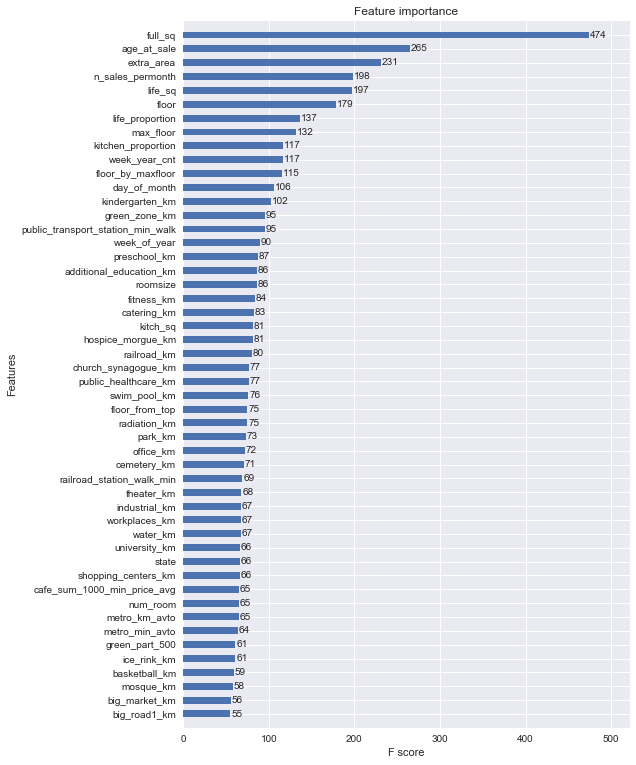

In [20]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=1000, max_depth=6, gamma=0, \
                          min_child_weight=3, seed=123, reg_alpha=1e7,\
                          subsample=.95, colsample_bytree=.95,nthread=-1,scale_pos_weight=1)
modelfit(xgbreg, X_train, predictors, target, outputMetrics=RMSLE_, XGBmetrics='rmse')
#343 columns full CV metrics : 0.4005

[0]	train-rmse:14.8216	test-rmse:14.8216
[50]	train-rmse:5.42157	test-rmse:5.42166
[100]	train-rmse:2.029	test-rmse:2.02933
[150]	train-rmse:0.862226	test-rmse:0.864906
[200]	train-rmse:0.533378	test-rmse:0.540216
[250]	train-rmse:0.465727	test-rmse:0.476009
[300]	train-rmse:0.450821	test-rmse:0.46375
[350]	train-rmse:0.444555	test-rmse:0.459801
[400]	train-rmse:0.440245	test-rmse:0.457728
[450]	train-rmse:0.436665	test-rmse:0.456317
[500]	train-rmse:0.433602	test-rmse:0.455308
[550]	train-rmse:0.430758	test-rmse:0.454527
[600]	train-rmse:0.42816	test-rmse:0.453991
[650]	train-rmse:0.425715	test-rmse:0.453536
[700]	train-rmse:0.423361	test-rmse:0.45325
[750]	train-rmse:0.421158	test-rmse:0.452992
[800]	train-rmse:0.41905	test-rmse:0.452737
[850]	train-rmse:0.417013	test-rmse:0.452649
[900]	train-rmse:0.414992	test-rmse:0.452541
[950]	train-rmse:0.413018	test-rmse:0.452403
[1000]	train-rmse:0.411122	test-rmse:0.452351
[1050]	train-rmse:0.409289	test-rmse:0.4523
[1100]	train-rmse:0.40754

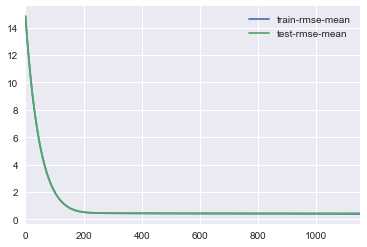

In [71]:
xgb_params = {
    'eta': .02,
    'max_depth': 4,
    'subsample': 0.95,
    'reg_alpha': 10,
    'min_child_weight':4,
    'colsample_bytree': 0.6,
    'gamma': 0.4,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 123
}

dtrain = xgb.DMatrix(X_train[predictors], np.log(y_train+1))
dtest = xgb.DMatrix(X_test[predictors])

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=2000, early_stopping_rounds=50,\
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

#    'eta': .1,'max_depth': 5,'subsample': 0.8,'reg_alpha': 0,'min_child_weight':5,'colsample_bytree': 0.8,
#'gamma': 0,'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree','tuneLength': 3,
#'seed': 123, CV: 0.455952
#    'eta': .1,'max_depth': 4,'subsample': 0.8,'reg_alpha': 0,'min_child_weight':4,'colsample_bytree': 0.8,
#'gamma': 0.4,'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree','tuneLength': 3,
#'seed': 123, CV: 0.455814
#    'eta': .1,'max_depth': 4,'subsample': 0.95,'reg_alpha': 0,'min_child_weight':4,'colsample_bytree': 0.6,
#'gamma': 0.4,'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree','tuneLength': 3,
#'seed': 123, CV: 0.454961
#    'eta': .1,'max_depth': 4,'subsample': 0.95,'reg_alpha': 10,'min_child_weight':4,'colsample_bytree': 0.6,
#'gamma': 0.4,'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree','tuneLength': 3,
#'seed': 123, CV: 0.454011
#    'eta': .05,'max_depth': 4,'subsample': 0.95,'reg_alpha': 10,'min_child_weight':4,'colsample_bytree': 0.6,
#'gamma': 0.4,'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree','tuneLength': 3,
#'seed': 123, CV: 0.452956
#    'eta': .02,'max_depth': 4,'subsample': 0.95,'reg_alpha': 10,'min_child_weight':4,'colsample_bytree': 0.6,
#'gamma': 0.4,'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree','tuneLength': 3,
#'seed': 123, CV: 0.452956, num1200

In [32]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=5, gamma=0, \
                          min_child_weight=3, seed=123, reg_alpha=0,\
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'max_depth': np.arange(3,10,2),
       'min_child_weight': np.arange(1,6,2),
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSE)
model.fit(X_train[predictors], np.log(y_train+1))
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.21525, std: 0.04378, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 1}, mean: -0.21568, std: 0.04408, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 3}, mean: -0.21556, std: 0.04352, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 5}, mean: -0.21635, std: 0.04396, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 1}, mean: -0.21534, std: 0.04286, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 3}, mean: -0.21499, std: 0.04282, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 5}, mean: -0.22100, std: 0.04408, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 1}, mean: -0.21947, std: 0.04256, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 3}, mean: -0.21991, std: 0.04359, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 5}, mean: -0.22669, std: 0.04081, params: {'seed': 123, 'max_depth': 9, 'min_child_weight': 1}, mean: -0.22729, std: 0.04

In [73]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=4, gamma=0, \
                          min_child_weight=4, seed=123, reg_alpha=0,\
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'max_depth': [4,5,6],
       'min_child_weight': [4,5,6],
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSE)
model.fit(X_train[predictors], np.log(y_train+1))
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.46108, std: 0.04420, params: {'seed': 123, 'max_depth': 4, 'min_child_weight': 4}, mean: -0.46111, std: 0.04473, params: {'seed': 123, 'max_depth': 4, 'min_child_weight': 5}, mean: -0.46050, std: 0.04443, params: {'seed': 123, 'max_depth': 4, 'min_child_weight': 6}, mean: -0.46205, std: 0.04454, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 4}, mean: -0.46158, std: 0.04405, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 5}, mean: -0.46120, std: 0.04459, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 6}, mean: -0.46387, std: 0.04484, params: {'seed': 123, 'max_depth': 6, 'min_child_weight': 4}, mean: -0.46414, std: 0.04455, params: {'seed': 123, 'max_depth': 6, 'min_child_weight': 5}, mean: -0.46389, std: 0.04281, params: {'seed': 123, 'max_depth': 6, 'min_child_weight': 6}], {'seed': 123, 'max_depth': 4, 'min_child_weight': 6})
Best CV Score:
0.460503658827
128.125078599


In [35]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=4, gamma=0, \
                          min_child_weight=4, seed=123, reg_alpha=0,\
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'gamma' : [i/10.0 for i in np.arange(0,5)],
       'max_depth': [4],
       'min_child_weight': [4],
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSE)
model.fit(X_train[predictors], np.log(y_train+1))
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.46108, std: 0.04420, params: {'seed': 123, 'max_depth': 4, 'gamma': 0.0, 'min_child_weight': 4}, mean: -0.46120, std: 0.04519, params: {'seed': 123, 'max_depth': 4, 'gamma': 0.10000000000000001, 'min_child_weight': 4}, mean: -0.46110, std: 0.04429, params: {'seed': 123, 'max_depth': 4, 'gamma': 0.20000000000000001, 'min_child_weight': 4}, mean: -0.46196, std: 0.04546, params: {'seed': 123, 'max_depth': 4, 'gamma': 0.29999999999999999, 'min_child_weight': 4}, mean: -0.46096, std: 0.04509, params: {'seed': 123, 'max_depth': 4, 'gamma': 0.40000000000000002, 'min_child_weight': 4}], {'seed': 123, 'max_depth': 4, 'gamma': 0.40000000000000002, 'min_child_weight': 4})
Best CV Score:
0.460957255326
33.8958628178


In [39]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=4, gamma=0.4, \
                          min_child_weight=4, seed=123, reg_alpha=0,\
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
    'subsample':[i/10.0 for i in np.arange(6,10)],
    'colsample_bytree':[i/10.0 for i in np.arange(6,10)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSE)
model.fit(X_train[predictors], np.log(y_train+1))
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

KeyboardInterrupt: 

In [26]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=4, gamma=0.4, \
                          min_child_weight=4, seed=123, reg_alpha=0,\
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
    'subsample':[i/100.0 for i in np.arange(85,100,5)],
    'colsample_bytree':[i/100.0 for i in np.arange(55,70,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSE)
model.fit(X_train[predictors], np.log(y_train+1))
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.45904, std: 0.04822, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.84999999999999998}, mean: -0.45837, std: 0.04670, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.84999999999999998}, mean: -0.45882, std: 0.04809, params: {'subsample': 0.94999999999999996, 'colsample_bytree': 0.84999999999999998}, mean: -0.45958, std: 0.04835, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.90000000000000002}, mean: -0.45826, std: 0.04803, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.90000000000000002}, mean: -0.45914, std: 0.04841, params: {'subsample': 0.94999999999999996, 'colsample_bytree': 0.90000000000000002}, mean: -0.45884, std: 0.04801, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.94999999999999996}, mean: -0.45842, std: 0.04831, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.94999999999999996}, mean: -0.45822, std: 0.04

In [65]:
#del xgbreg
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=200, max_depth=4, gamma=0, \
                          min_child_weight=4, seed=123, reg_alpha=0,\
                          subsample=.95, colsample_bytree=.6,nthread=-1,scale_pos_weight=1)
param_grid = {
    'reg_alpha':[1e-3,1e-2,1e-1,1e0]#[1e-5, 1e-2, .1, 1, 100]
    #'subsample':[i/100.0 for i in np.arange(85,100,5)],
    #'colsample_bytree':[i/100.0 for i in np.arange(85,100,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSE)
model.fit(X_train[predictors], np.log(y_train+1))
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.46144, std: 0.04491, params: {'reg_alpha': 0.001}, mean: -0.46157, std: 0.04570, params: {'reg_alpha': 0.01}, mean: -0.46107, std: 0.04474, params: {'reg_alpha': 0.1}, mean: -0.46014, std: 0.04529, params: {'reg_alpha': 1.0}], {'reg_alpha': 1.0})
Best CV Score:
0.460139001327
5.78023203214


In [68]:
#del xgbreg
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=200, max_depth=4, gamma=0, \
                          min_child_weight=4, seed=123, reg_alpha=0,\
                          subsample=.95, colsample_bytree=.6,nthread=-1,scale_pos_weight=1)
param_grid = {
    'reg_alpha':[8e0,1e1,1.5e1]#[1e-5, 1e-2, .1, 1, 100]
    #'subsample':[i/100.0 for i in np.arange(85,100,5)],
    #'colsample_bytree':[i/100.0 for i in np.arange(85,100,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSE)
model.fit(X_train[predictors], np.log(y_train+1))
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.46012, std: 0.04517, params: {'reg_alpha': 8.0}, mean: -0.45939, std: 0.04539, params: {'reg_alpha': 10.0}, mean: -0.46000, std: 0.04517, params: {'reg_alpha': 15.0}], {'reg_alpha': 10.0})
Best CV Score:
0.459392466117
4.53366218011


In [72]:
xgb_params = {
    'eta': .02,
    'max_depth': 4,
    'subsample': 0.95,
    'reg_alpha': 10,
    'min_child_weight':4,
    'colsample_bytree': 0.6,
    'gamma': 0.4,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 123
}
num_rounds=1200

X_fit, X_val, y_fit, y_val=train_test_split(X_train[predictors], np.log(y_train+1), test_size=0.2, \
                                            random_state=123)
xgfit = xgb.DMatrix(X_fit, label=y_fit)
xgval = xgb.DMatrix(X_val, label=y_val)
watchlist = [ (xgfit,'train'), (xgval, 'test') ]
#clfCV = xgb.train(xgb_params, xgfit, num_rounds)
clfCV = xgb.train(xgb_params, xgfit, num_rounds, watchlist, early_stopping_rounds=20)

y_val_pred = np.exp(clfCV.predict(xgval))-1
RMSLE_(y_val,y_val_pred)
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5} 0.44153281251502002
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5} #year 
#0.44060260149809333
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5} #further feat
# 0.44209231186019138
# 'eta': 0.2, 'max_depth': 4,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear','eval_metric': 'rmse',
#'silent': 1,'booster' :'gbtree','tuneLength': 3,'seed': 123, 0.44795306064489548
# 'eta': 0.05, 'max_depth': 7,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear','eval_metric': 'rmse',
#'silent': 1,'booster' :'gbtree','tuneLength': 3,'seed': 5, 0.43906751173727021
# 'eta': 0.05, 'max_depth': 7,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear','eval_metric': 'rmse',
#'silent': 1,'booster' :'gbtree','tuneLength': 3,'seed': 123, 0.43867312921244639

#'eta': 0.1,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree',
#'tuneLength': 3,'seed': 123, 0.44006308323535842

#'eta': 0.05,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree',
#'tuneLength': 3,'seed': 123, 0.43956845066724409

#'eta': 0.01,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree',
#'tuneLength': 3,'seed': 123, 0.44026780405377181

#'eta': 0.1,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree', 'reg_alpha': 0,
#'tuneLength': 3,'seed': 123, 0.44012755182473617

#'eta': 0.05,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree', 'reg_alpha': 0,
#'tuneLength': 3,'seed': 123, 0.43836880534269967

#'eta': 0.02,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree', 'reg_alpha': 0,
#'tuneLength': 3,'seed': 123, 0.43755608914917643

#'eta': 0.02,'max_depth': 4,'subsample': 0.95,'min_child_weight':4,'colsample_bytree': 0.6,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree', 'reg_alpha': 10,
#'tuneLength': 3,'seed': 123, 0.438327

[0]	train-rmse:14.8206	test-rmse:14.8253
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:14.5247	test-rmse:14.5295
[2]	train-rmse:14.2346	test-rmse:14.2394
[3]	train-rmse:13.9504	test-rmse:13.9552
[4]	train-rmse:13.6719	test-rmse:13.6767
[5]	train-rmse:13.399	test-rmse:13.4038
[6]	train-rmse:13.1315	test-rmse:13.1363
[7]	train-rmse:12.8694	test-rmse:12.8742
[8]	train-rmse:12.6125	test-rmse:12.6174
[9]	train-rmse:12.3608	test-rmse:12.3657
[10]	train-rmse:12.1142	test-rmse:12.1191
[11]	train-rmse:11.8725	test-rmse:11.8773
[12]	train-rmse:11.6356	test-rmse:11.6404
[13]	train-rmse:11.4034	test-rmse:11.4082
[14]	train-rmse:11.176	test-rmse:11.1808
[15]	train-rmse:10.953	test-rmse:10.9579
[16]	train-rmse:10.7346	test-rmse:10.7394
[17]	train-rmse:10.5205	test-rmse:10.5253
[18]	train-rmse:10.3107	test-rmse:10.3155
[19]	train-rmse:10.1051	test-rmse:10.11
[20]	train-rmse:9.90362	test-rms

12.801461183994128

In [16]:
# t0=time()
# xgbreg = xgb.XGBRegressor()
# param_grid = {
#        #'n_estimators': [500],
#        'learning_rate': [0.05, .15, .2, .25], #[.05], #
#        'max_depth': [3, 4,5,6,7],
#        'subsample': [.65, 0.7, .75], #[.7], #
#        'colsample_bytree': [.65, 0.7, 0.75], #[.7],#
#         'seed':[123]#np.arange(20)
# }
# model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
# model.fit(X_train, y_train)
# print('eXtreme Gradient Boosting regression...')
# print('Best Params:')
# print(model.best_params_)
# print('Best CV Score:')
# print(-model.best_score_)
# print((time()-t0)/60)




# # eXtreme Gradient Boosting regression...
# # Best Params:
# # {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5}
# # Best CV Score:
# # 0.468277454751
# ##################
# # eXtreme Gradient Boosting regression...
# # Best Params:
# # {'subsample': 0.7, 'learning_rate': 0.045, 'seed': 123, 'colsample_bytree': 0.65, 'max_depth': 6}
# # Best CV Score:
# # 0.466023945905
# # {'subsample': 0.75, 'learning_rate': 0.045, 'seed': 123, 'colsample_bytree': 0.75, 'max_depth': 7}
# # Best CV Score:
# # 0.464491819425
# # Best Params:
# # {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 123, 'colsample_bytree': 0.7, 'max_depth': 7}
# # Best CV Score:
# # 0.460651355555

param_grid = {'eta':[.05], 'num_round':[500], 'subsample':[.7], 'colsample_bytree':[.7], \
              'max_depth':[5], 'seed':[2017,213,5]}
for eta in param_grid['eta']:
    for subsample in param_grid['subsample']:
        for colsample_bytree in param_grid['colsample_bytree']:
            for max_depth in param_grid['max_depth']:
                for seed in param_grid['seed']:
                    for num_rounds in param_grid['num_round']:
                        model=xgbClass(colsample_bytree=colsample_bytree, eta=eta, eva_metric='rmse', \
                                       subsample=subsample, max_depth=max_depth, seed=seed,\
                                       objective='reg:linear', num_class=1,num_rounds=num_rounds,\
                                       early_stopping_rounds=20)
                        score=CVScore(model=model, n_splits=3, my_score=RMSLE, X_train=X_train,\
                                  y_train=y_train)
                        del model
                        print('eta={}, subsample={}, colsample_bytree={}, max_depth={}, seed={}, score={}, num_rounds={}'.\
                          format(eta, subsample, colsample_bytree, max_depth, seed, score, num_rounds))

[0]	train-rmse:14.3684	test-rmse:14.3685
[50]	train-rmse:1.19998	test-rmse:1.20264
[100]	train-rmse:0.451103	test-rmse:0.46805
[150]	train-rmse:0.430815	test-rmse:0.456529
[200]	train-rmse:0.42191	test-rmse:0.455161
[250]	train-rmse:0.414314	test-rmse:0.454614
[300]	train-rmse:0.408127	test-rmse:0.454332
[350]	train-rmse:0.402083	test-rmse:0.454084


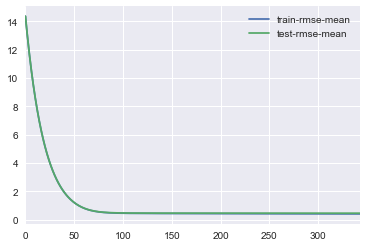

In [59]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.95,
    'reg_alpha': 0,
    'min_child_weight':4,
    'colsample_bytree': 0.95,
    'gamma':.4,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 5
}

dtrain = xgb.DMatrix(X_train[predictors], np.log(y_train+1))
dtest = xgb.DMatrix(X_test[predictors])

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=2000, early_stopping_rounds=50,\
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
#'eta': 0.05,'max_depth': 4,'subsample': 0.95,'reg_alpha': 0,'min_child_weight':4,'colsample_bytree': 0.95,
#'gamma':.4,'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree','tuneLength': 3,
#'seed': 123 test-rmse:0.454117
#'eta': 0.02,'max_depth': 4,'subsample': 0.95,'reg_alpha': 0,'min_child_weight':4,'colsample_bytree': 0.95,
#'gamma':.4,'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree','tuneLength': 3,
#'seed': 123 test-rmse:test-rmse:0.453764

In [60]:
# xgb_params = {
#     'eta': 0.05,
#     'max_depth': 4,
#     'subsample': 0.9,
#     'reg_alpha': 0,
#     'min_child_weight':4,
#     'colsample_bytree': 0.9,
#     'gamma':.4,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'silent': 1,
#     'booster' :'gbtree',
#     'tuneLength': 3,
#     'seed': 123
# }

dtrain = xgb.DMatrix(X_train[predictors], np.log(y_train+1))
dtest = xgb.DMatrix(X_test[predictors])

num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#fig, ax = plt.subplots(1, 1, figsize=(8, 13))
#xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_predict = model.predict(dtest)
y_predict = np.exp(y_predict)-1
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})



xgb_params = {
    'eta': .02,#0.02,
    'max_depth': 6,
    'subsample': 0.95,
    'reg_alpha': 1e7,
    'min_child_weight':3,
    'colsample_bytree': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 5
}

dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors])

num_boost_rounds = 250#len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#fig, ax = plt.subplots(1, 1, figsize=(8, 13))
#xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_predict = model.predict(dtest)
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})



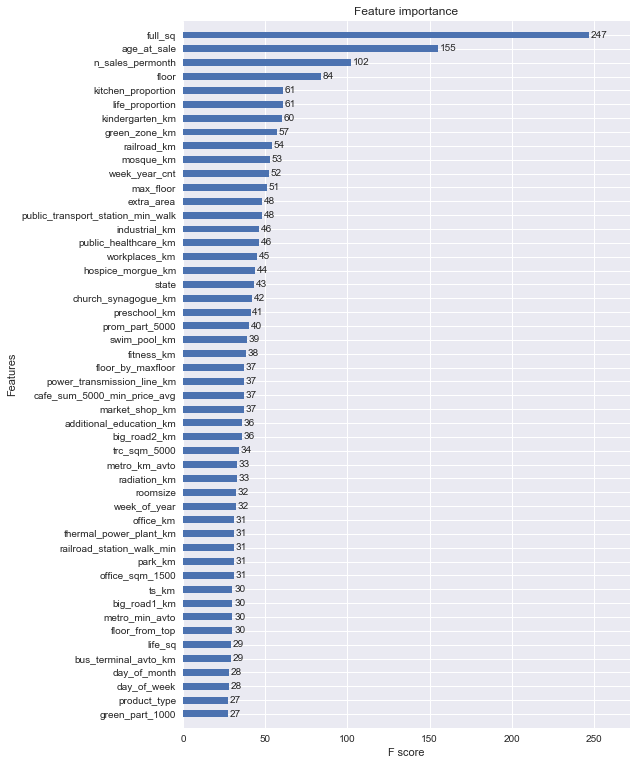

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [62]:
 output.to_csv('Jun15_5_seed5_AddFeat_paraTuning_etaPt05_subsPt9_maxD4_childH4.csv', index=False)

In [39]:
(output<0).sum()

id           0
price_doc    0
dtype: int64